In [97]:
import sys
sys.path.append('/home/daniel/Documents/Uni/MT/poi-prediction/')
import pandas as pd
from src.eval import create_prediction_df, run_predictions, create_prediction_poi_files, compute_overall_metrics, compute_poi_wise_metrics, compute_vert_wise_metrics
from BIDS.POI_plotter import visualize_pois
from BIDS import POI

In [98]:
def viz_poi(
    paths_dict,
    sub,
    vert,
    poi_type = 'pred',
    poi_list = None,
):
    poi_path = paths_dict[sub, vert][poi_type]
    seg_vert = paths_dict[sub, vert]['seg_vert']
    poi = POI.load(poi_path).copy()
    if poi_list is not None:
        new_centroids = {}
        for v, p, c in poi.items():
            if p in poi_list:
                new_centroids[v, p] = c
        poi.centroids = new_centroids
    
    visualize_pois(poi, seg_vert, vert_idx_list = [vert])

In [99]:
dm_path = '/home/daniel/Documents/Uni/MT/experiment_logs/gruber/no_surface/all_pois/no_freeze/SA-DenseNet-PatchTransformer/version_0/data_module_params.json'
model_path = '/home/daniel/Documents/Uni/MT/experiment_logs/gruber/no_surface/all_pois/no_freeze/SA-DenseNet-PatchTransformer/version_0/checkpoints/sad-pt-epoch=39-fine_mean_distance_val=2.40.ckpt'

In [100]:
poi_paths = create_prediction_poi_files(dm_path, model_path, poi_file_ending='test_poi.json', save_path='/home/daniel/prediction_files/', split='val', return_paths = True)
pred_df = create_prediction_df(dm_path, model_path, split='val')

In [102]:
pred_df.sort_values(by='refined_proj_error', ascending = False, inplace=True)
pred_df.head()

,subject,vertebra,poi_idx,target,coarse,refined,coarse_proj,refined_proj,coarse_proj_dist,refined_proj_dist,loss_mask,coarse_error,refined_error,coarse_proj_error,refined_proj_error
1299,WS-26,17,119,"[47.014, 85.019, 41.823997]","[55.737457, 96.226135, 42.885998]","[55.184334, 96.72712, 41.291744]","[56, 97, 43]","[55, 96, 42]",0.825101,1.031653,True,14.241716,14.286979,15.022503,13.579013
1343,WS-26,19,117,"[42.827, 82.756, 59.962]","[51.67016, 91.13588, 61.04699]","[51.653503, 91.804214, 61.074226]","[52, 91, 61]","[52, 91, 61]",0.359815,0.878823,True,12.231153,12.689147,12.376791,12.376791
388,WS-45,20,144,"[24.526001, 52.869, 57.241]","[30.661514, 44.202747, 54.486134]","[31.57034, 44.079735, 54.36492]","[32, 44, 54]","[32, 44, 54]",1.438394,0.569328,False,10.969856,11.625218,12.042587,12.042587
1490,WS-62,3,142,"[88.934, 63.288002, 51.1]","[90.44885, 71.29215, 43.655167]","[89.67195, 72.51259, 44.500153]","[89, 73, 45]","[89, 73, 45]",2.612373,0.968987,True,11.035703,11.366422,11.468969,11.468969
1492,WS-62,3,144,"[39.343, 65.531, 54.65]","[37.65312, 74.82089, 48.24661]","[38.215904, 74.82366, 48.219604]","[38, 75, 49]","[38, 75, 49]",0.848531,0.828690,False,11.408824,11.356670,11.108022,11.108022


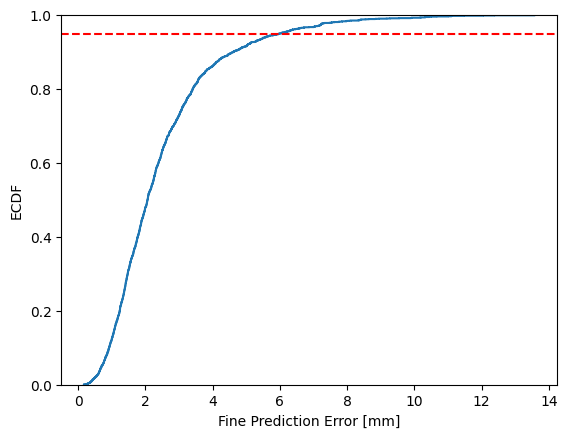

95th percentile: 5.98 mm


In [103]:
#Plot cdf of refined_proj_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots()
sns.ecdfplot(data=pred_df, x='refined_proj_error', ax=ax)
ax.set_xlabel('Fine Prediction Error [mm]')
ax.set_ylabel('ECDF')
#Draw horizontal line at 90th percentile
percentile = 95
percentile_val = np.percentile(pred_df['refined_proj_error'], percentile)
ax.axhline(y=percentile/100, color='r', linestyle='--', label=f'{percentile}th percentile')
plt.show()
print(f'{percentile}th percentile: {percentile_val:.2f} mm')

In [104]:
#Get all predictions above 95th percentile
outliers = pred_df[pred_df['refined_proj_error'] > percentile_val]
outliers

,subject,vertebra,poi_idx,target,coarse,refined,coarse_proj,refined_proj,coarse_proj_dist,refined_proj_dist,loss_mask,coarse_error,refined_error,coarse_proj_error,refined_proj_error
1299,WS-26,17,119,"[47.014, 85.019, 41.823997]","[55.737457, 96.226135, 42.885998]","[55.184334, 96.72712, 41.291744]","[56, 97, 43]","[55, 96, 42]",0.825101,1.031653,True,14.241716,14.286979,15.022503,13.579013
1343,WS-26,19,117,"[42.827, 82.756, 59.962]","[51.67016, 91.13588, 61.04699]","[51.653503, 91.804214, 61.074226]","[52, 91, 61]","[52, 91, 61]",0.359815,0.878823,True,12.231153,12.689147,12.376791,12.376791
388,WS-45,20,144,"[24.526001, 52.869, 57.241]","[30.661514, 44.202747, 54.486134]","[31.57034, 44.079735, 54.36492]","[32, 44, 54]","[32, 44, 54]",1.438394,0.569328,False,10.969856,11.625218,12.042587,12.042587
1490,WS-62,3,142,"[88.934, 63.288002, 51.1]","[90.44885, 71.29215, 43.655167]","[89.67195, 72.51259, 44.500153]","[89, 73, 45]","[89, 73, 45]",2.612373,0.968987,True,11.035703,11.366422,11.468969,11.468969
1492,WS-62,3,144,"[39.343, 65.531, 54.65]","[37.65312, 74.82089, 48.24661]","[38.215904, 74.82366, 48.219604]","[38, 75, 49]","[38, 75, 49]",0.848531,0.828690,False,11.408824,11.356670,11.108022,11.108022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,WS-16,24,117,"[45.065, 99.686, 57.218]","[50.21502, 103.59961, 54.958355]","[50.251694, 103.0254, 55.897465]","[50, 103, 55]","[50, 103, 56]",0.638356,0.272962,True,6.851647,6.308503,6.344791,6.067979
789,WS-16,16,111,"[73.183, 94.857, 43.837997]","[67.58506, 97.19457, 44.231552]","[67.598854, 98.02259, 44.098152]","[68, 97, 44]","[68, 98, 44]",0.513469,0.413597,True,6.079148,6.424274,5.610896,6.063675
862,WS-16,19,119,"[44.246002, 93.266, 42.427002]","[48.842693, 97.20351, 43.847282]","[48.06563, 97.92618, 41.861565]","[49, 97, 44]","[49, 97, 42]",0.299137,1.322881,True,6.216971,6.051988,6.246406,6.060164
973,WS-16,24,111,"[78.486, 95.636, 28.76]","[73.564964, 98.63875, 28.191238]","[73.98271, 98.59829, 27.611273]","[73, 98, 28]","[73, 98, 28]",0.873931,1.214406,True,5.792803,5.511291,6.021817,6.021817


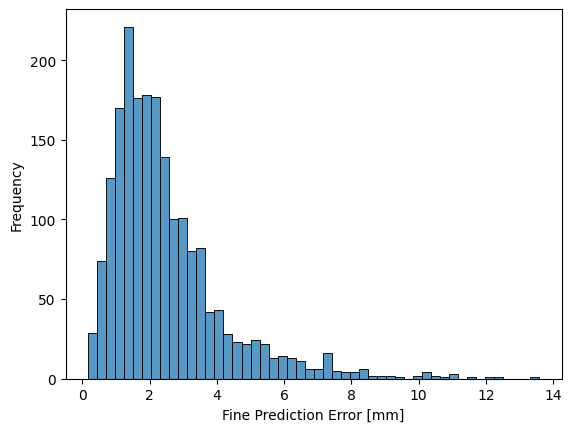

In [105]:
#Plot as histogram
fig, ax = plt.subplots()
sns.histplot(data=pred_df, x='refined_proj_error', bins=50, ax=ax)
ax.set_xlabel('Fine Prediction Error [mm]')
ax.set_ylabel('Frequency')
plt.show()

In [106]:
#Get performance metrics per POI type
poi_metrics = compute_poi_wise_metrics(pred_df)
poi_metrics

,Mean Error,Median Error,MSE,Accuracy,Max Error
poi_idx,,,,,
81,1.775789,1.533421,4.239756,0.686047,7.237868
101,1.531020,1.462117,2.650239,0.825581,3.216745
102,1.656276,1.561459,3.239729,0.697674,3.626744
103,1.890743,1.792049,4.297387,0.593023,4.130745
104,1.854268,1.660674,4.407848,0.674419,6.274813
109,3.219230,2.741098,14.204726,0.313953,10.325963
110,1.978034,1.853347,4.910365,0.546512,5.013861
111,3.906063,3.699441,19.595736,0.197674,8.425513
112,2.511310,2.360822,7.709928,0.360465,6.159191


In [107]:
#Group POIs 109, 117, 111, 119,112,120,149,141,151,143 together
outer_pois = [109, 117, 111, 119,112,120,149,141,151,143,110,118]

#Group POIs 101, 103, 102, 102, 125, 127
sagittal_pois = [101, 103, 102, 104, 125, 127]

itl_pois = [142, 144]

spinous_pois = [81, 134, 136]

#In the poi_wise metrics dataframe, create a new column 'group' that assigns the POI to the respective group
poi_metrics['group'] = 'Other'
poi_metrics.loc[outer_pois, 'group'] = 'Outer'
poi_metrics.loc[sagittal_pois, 'group'] = 'Sagittal'
poi_metrics.loc[itl_pois, 'group'] = 'ITL'
poi_metrics.loc[spinous_pois, 'group'] = 'Spinous'


#Compute metrics per group
group_metrics = poi_metrics.groupby('group').mean()
print(group_metrics.to_latex())
group_metrics

\begin{tabular}{lrrrrr}
\toprule
 & Mean Error & Median Error & MSE & Accuracy & Max Error \\
group &  &  &  &  &  \\
\midrule
ITL & 2.927994 & 1.996729 & 15.304228 & 0.488372 & 11.755778 \\
Outer & 2.842875 & 2.550815 & 11.383184 & 0.376938 & 8.161242 \\
Sagittal & 1.898124 & 1.762325 & 4.456512 & 0.627907 & 4.649172 \\
Spinous & 2.015180 & 1.783621 & 5.620538 & 0.585271 & 6.506870 \\
\bottomrule
\end{tabular}



,Mean Error,Median Error,MSE,Accuracy,Max Error
group,,,,,
ITL,2.927994,1.996729,15.304228,0.488372,11.755778
Outer,2.842875,2.550815,11.383184,0.376938,8.161242
Sagittal,1.898124,1.762325,4.456512,0.627907,4.649172
Spinous,2.015180,1.783621,5.620538,0.585271,6.506870


In [108]:
#Get number of samples per group in outliers
outliers['group'] = 'Other'

#map poi_idx to group
outliers.loc[outliers['poi_idx'].isin(outer_pois), 'group'] = 'Outer'
outliers.loc[outliers['poi_idx'].isin(sagittal_pois), 'group'] = 'Sagittal'
outliers.loc[outliers['poi_idx'].isin(itl_pois), 'group'] = 'ITL'
outliers.loc[outliers['poi_idx'].isin(spinous_pois), 'group'] = 'Spinous'

outliers_group_counts = outliers.groupby('group')['refined_proj_error'].describe()
print(outliers_group_counts.to_latex())
outliers_group_counts

\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
group &  &  &  &  &  &  &  &  \\
\midrule
ITL & 19.000000 & 9.458239 & 1.800691 & 6.192741 & 8.333256 & 10.163127 & 10.832188 & 12.042587 \\
Outer & 74.000000 & 7.400302 & 1.405329 & 5.988021 & 6.387238 & 7.180708 & 7.854806 & 13.579013 \\
Sagittal & 1.000000 & 6.274813 & NaN & 6.274813 & 6.274813 & 6.274813 & 6.274813 & 6.274813 \\
Spinous & 5.000000 & 7.195784 & 0.051270 & 7.120663 & 7.164419 & 7.223369 & 7.232602 & 7.237868 \\
\bottomrule
\end{tabular}



####################################
/tmp/ipykernel_960320/674386693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['group'] = 'Other'
  File "/home/daniel/anaconda3/envs/thesis/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/daniel/anaconda3/envs/thesis/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/daniel/anaconda3/envs/thesis/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/daniel/anaconda3/envs/thesis/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/home/daniel/anaconda3/envs/thes

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
ITL,19.0,9.458239,1.800691,6.192741,8.333256,10.163127,10.832188,12.042587
Outer,74.0,7.400302,1.405329,5.988021,6.387238,7.180708,7.854806,13.579013
Sagittal,1.0,6.274813,NaN,6.274813,6.274813,6.274813,6.274813,6.274813
Spinous,5.0,7.195784,0.051270,7.120663,7.164419,7.223369,7.232602,7.237868


In [78]:
#Compute the outliers again but drop subject WS-15
pred_df_no_ws15 = pred_df[pred_df['subject'] != 'WS-15']
outliers_no_ws15 = pred_df_no_ws15[pred_df_no_ws15['refined_proj_error'] > percentile_val]
outliers_no_ws15['group'] = 'Other'
outliers_no_ws15.loc[outliers_no_ws15['poi_idx'].isin(outer_pois), 'group'] = 'Outer'
outliers_no_ws15.loc[outliers_no_ws15['poi_idx'].isin(sagittal_pois), 'group'] = 'Sagittal'
outliers_no_ws15.loc[outliers_no_ws15['poi_idx'].isin(itl_pois), 'group'] = 'ITL'
outliers_no_ws15.loc[outliers_no_ws15['poi_idx'].isin(spinous_pois), 'group'] = 'Spinous'
outliers_no_ws15_group_counts = outliers_no_ws15['group'].value_counts()
print(outliers_no_ws15_group_counts.to_latex())
outliers_no_ws15_group_counts

\begin{tabular}{lr}
\toprule
 & count \\
group &  \\
\midrule
Outer & 74 \\
ITL & 19 \\
Spinous & 5 \\
Sagittal & 1 \\
\bottomrule
\end{tabular}



####################################
/tmp/ipykernel_960320/3642221954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_no_ws15['group'] = 'Other'
  File "/home/daniel/anaconda3/envs/thesis/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/daniel/anaconda3/envs/thesis/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/daniel/anaconda3/envs/thesis/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/daniel/anaconda3/envs/thesis/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/home/daniel/anaconda3/

group
Outer       74
ITL         19
Spinous      5
Sagittal     1
Name: count, dtype: int64

In [109]:
#Get the spinous outliers wihtout WS-15
spinous_outliers = outliers[outliers['group'] == 'Spinous']
spinous_outliers

,subject,vertebra,poi_idx,target,coarse,refined,coarse_proj,refined_proj,coarse_proj_dist,refined_proj_dist,loss_mask,coarse_error,refined_error,coarse_proj_error,refined_proj_error,group
46,WS-45,5,81,"[63.783, 43.317, 48.818]","[60.939987, 39.282806, 46.41778]","[58.67156, 39.948105, 46.432568]","[59, 41, 46]","[58, 40, 46]",2.624280,0.800499,True,5.488033,6.570129,6.015540,7.237868,Spinous
1925,WS-62,22,136,"[64.122, 25.821, 25.96]","[65.141, 31.252312, 24.998974]","[64.60227, 33.365032, 25.567858]","[65, 32, 26]","[65, 33, 26]",1.257367,0.691508,True,5.609018,7.569469,6.241196,7.232602,Spinous
62,WS-45,5,136,"[64.050995, 46.829002, 46.829002]","[61.229496, 41.672623, 44.22372]","[59.70205, 41.82471, 44.142807]","[60, 43, 45]","[59, 42, 45]",1.968807,1.121775,True,6.429355,7.153454,5.866606,7.223369,Spinous
476,WS-45,24,136,"[68.747, 25.470001, 42.5]","[67.595566, 28.736198, 37.7348]","[68.16532, 29.858255, 37.004555]","[68, 29, 38]","[68, 30, 37]",0.550899,0.217815,True,5.890755,7.056561,5.767920,7.164419,Spinous
499,WS-16,3,136,"[67.785995, 50.79, 43.313]","[64.45973, 46.911537, 44.28941]","[64.50128, 45.230476, 44.88284]","[64, 47, 44]","[64, 45, 45]",0.550397,0.564030,True,5.201912,6.645454,5.400911,7.120663,Spinous


In [110]:
#Get the 
pred_df.groupby(['subject', 'vertebra'])['refined_proj_error'].describe().sort_values(by='mean', ascending = False)

count      mean       std       min       25%       50%  \
subject vertebra                                                            
WS-26   17         23.0  3.734173  3.131866  0.774405  2.016044  2.478818   
WS-62   7          23.0  3.397572  1.317118  0.997020  2.357871  3.352561   
WS-26   19         23.0  3.311276  3.074941  0.564720  1.230303  2.264981   
WS-62   22         23.0  3.269859  1.822892  0.768159  1.635102  3.420906   
        4          23.0  3.252873  2.582819  1.093930  1.658996  2.561771   
...                 ...       ...       ...       ...       ...       ...   
WS-45   23         23.0  1.705326  0.900816  0.346550  1.054055  1.634940   
        22         23.0  1.609113  1.020235  0.366830  0.936308  1.404830   
        21         23.0  1.521762  0.597429  0.547490  1.143681  1.420048   
WS-16   4          23.0  1.510878  0.753961  0.373207  0.910893  1.410826   
WS-26   4          23.0  1.442784  0.824575  0.431808  0.967354  1.247690   

                       75%        max  
subject vertebra                       
WS-26   17        4.061101  13.579013  
WS-62   7         4.348794   5.715834  
WS-26   19        3.582753  12.376791  
WS-62   22        4.536739   7.232602  
        4         3.488001  11.101265  
...                    ...        ...  
WS-45   23        2.111987   3.885606  
        22        1.974842   4.089906  
        21        1.790633   3.234347  
WS-16   4         1.854394   3.466229  
WS-26   4         1.557143   3.495860  

[86 rows x 8 columns]

In [111]:
#Get all entries in pred_df where the refined_proj_error is above 10 and loss mask is true
larger_errors = pred_df[pred_df['refined_proj_error'] > percentile_val]
larger_errors = larger_errors[larger_errors['loss_mask'] == True]

larger_errors.groupby(['subject'])['refined_proj_error'].describe().sort_values(by='count', ascending = False)

,count,mean,std,min,25%,50%,75%,max
subject,,,,,,,,
WS-16,38.0,6.865277,0.685918,6.021817,6.327921,6.799820,7.230843,9.173540
WS-26,24.0,8.634399,1.859920,6.296895,7.487435,8.364588,9.645561,13.579013
WS-62,18.0,8.329073,1.862333,5.988021,6.622818,7.981660,10.192066,11.468969
WS-45,6.0,7.298124,0.578613,6.567980,7.179157,7.230618,7.241770,8.352036


In [112]:
#Subject 15 is obviously wrongly annotated, so drop it
larger_errors.groupby(['subject'])['refined_proj_error'].describe().sort_values(by='count', ascending = False)

,count,mean,std,min,25%,50%,75%,max
subject,,,,,,,,
WS-16,38.0,6.865277,0.685918,6.021817,6.327921,6.799820,7.230843,9.173540
WS-26,24.0,8.634399,1.859920,6.296895,7.487435,8.364588,9.645561,13.579013
WS-62,18.0,8.329073,1.862333,5.988021,6.622818,7.981660,10.192066,11.468969
WS-45,6.0,7.298124,0.578613,6.567980,7.179157,7.230618,7.241770,8.352036


In [113]:
#Get the worst distance for either type 142 or 144
worst_itl = pred_df[(pred_df['poi_idx'] == 142) | (pred_df['poi_idx'] == 144)].sort_values(by='refined_proj_error', ascending = False).head(10)

#Remove subject WS-15
worst_itl_no_ws15 = worst_itl[worst_itl['subject'] != 'WS-15']

#Get the subject counts
worst_itl_no_ws15['subject'].head(8)

388     WS-45
1490    WS-62
1492    WS-62
1515    WS-62
110     WS-45
1377    WS-26
1513    WS-62
1607    WS-62
Name: subject, dtype: object

In [117]:
#Get three random outliers for visualization
random_outliers = pred_df[pred_df['refined_proj_error'] > percentile_val].sample(5)
random_outliers

,subject,vertebra,poi_idx,target,coarse,refined,coarse_proj,refined_proj,coarse_proj_dist,refined_proj_dist,loss_mask,coarse_error,refined_error,coarse_proj_error,refined_proj_error
1247,WS-26,15,109,"[73.017, 90.78, 65.725]","[67.29624, 95.54558, 64.309616]","[67.39143, 96.135605, 64.32957]","[67, 95, 64]","[67, 95, 64]",0.693741,1.245565,True,7.578991,7.891560,7.549059,7.549059
1270,WS-26,16,109,"[74.101, 89.757, 64.934]","[67.929535, 96.0655, 63.74883]","[67.24881, 96.54115, 63.82283]","[68, 95, 64]","[67, 97, 63]",1.096968,0.974421,True,8.904420,9.706279,8.098366,10.325963
948,WS-16,23,109,"[76.683, 101.674, 69.157]","[71.91265, 105.1106, 67.63048]","[71.39196, 104.45957, 68.27758]","[71, 104, 68]","[71, 104, 68]",1.484223,0.664748,True,6.074265,6.043828,6.248630,6.248630
499,WS-16,3,136,"[67.785995, 50.79, 43.313]","[64.45973, 46.911537, 44.28941]","[64.50128, 45.230476, 44.88284]","[64, 47, 44]","[64, 45, 45]",0.550397,0.564030,True,5.201912,6.645454,5.400911,7.120663
1549,WS-62,6,112,"[68.618, 73.854004, 33.98]","[67.1669, 73.594376, 40.09118]","[67.5109, 73.55808, 39.893394]","[67, 75, 40]","[68, 75, 40]",1.418432,1.526338,False,6.286461,6.023410,6.338109,6.159191


In [12]:
def viz_comparison(sub, vert, poi_list, reference_sub):
    for type in ['pred', 'gt']:
        viz_poi(
            poi_paths,
            sub,
            vert,
            poi_type = type,
            poi_list = poi_list
        )
    viz_poi(
        poi_paths,
        reference_sub,
        vert=vert,
        poi_type = 'gt',
        poi_list = poi_list
    )

In [120]:
for vert in [7]:
    viz_comparison('WS-45', vert, [142], 'WS-16')

[ ] Image reoriented from ('L', 'A', 'S') to ('P', 'I', 'R')
[*] Centroids reoriented from ('L', 'A', 'S') to ('P', 'I', 'R')
('P', 'I', 'R') ('P', 'I', 'R')


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 79.24it/s]


Widget(value="<iframe src='http://localhost:37805/index.html?ui=P_0x708ca10886d0_72&reconnect=auto' style='wid…

[ ] Image reoriented from ('L', 'A', 'S') to ('P', 'I', 'R')
[*] Centroids reoriented from ('L', 'A', 'S') to ('P', 'I', 'R')
('P', 'I', 'R') ('P', 'I', 'R')


100%|██████████| 1/1 [00:00<00:00, 90.93it/s]


Widget(value="<iframe src='http://localhost:37805/index.html?ui=P_0x708988be33d0_73&reconnect=auto' style='wid…

[ ] Image reoriented from ('L', 'A', 'S') to ('P', 'I', 'R')
[*] Centroids reoriented from ('L', 'A', 'S') to ('P', 'I', 'R')
('P', 'I', 'R') ('P', 'I', 'R')


100%|██████████| 1/1 [00:00<00:00, 91.37it/s]


Widget(value="<iframe src='http://localhost:37805/index.html?ui=P_0x708987f16620_74&reconnect=auto' style='wid…

In [119]:
#Set loss mask to True for subject 62, vertebra [3,4,5,8,10,11] and poi 142, 144
pred_df.loc[(pred_df['subject'] == 'WS-62') & (pred_df['vertebra'].isin([3,4,5,8,10,11])) & (pred_df['poi_idx'].isin([142, 144])), 'loss_mask'] = True

In [121]:
#Get the worst refined_proj_error where loss mask is false
worst_errors = pred_df[pred_df['loss_mask'] == False].sort_values(by='refined_proj_error', ascending = False).head(10)
worst_errors

,subject,vertebra,poi_idx,target,coarse,refined,coarse_proj,refined_proj,coarse_proj_dist,refined_proj_dist,loss_mask,coarse_error,refined_error,coarse_proj_error,refined_proj_error
388,WS-45,20,144,"[24.526001, 52.869, 57.241]","[30.661514, 44.202747, 54.486134]","[31.57034, 44.079735, 54.36492]","[32, 44, 54]","[32, 44, 54]",1.438394,0.569328,False,10.969856,11.625218,12.042587,12.042587
110,WS-45,7,142,"[93.026, 84.015, 58.168]","[95.900955, 86.44827, 48.740273]","[95.52128, 87.09464, 47.653267]","[96, 87, 49]","[96, 87, 48]",0.617795,0.598628,False,10.152251,11.237001,10.089951,11.006503
112,WS-45,7,144,"[34.961998, 84.58, 57.600998]","[32.84667, 87.39425, 48.000282]","[32.62199, 86.391205, 47.941883]","[33, 87, 48]","[33, 86, 48]",0.423016,0.547093,False,10.225867,10.102207,10.093809,9.901767
732,WS-16,13,143,"[43.850998, 52.332, 54.86]","[51.19741, 54.95357, 54.455967]","[51.57333, 54.0542, 55.244404]","[51, 54, 56]","[52, 54, 56]",1.825461,0.869431,False,7.810612,7.921373,7.429001,8.395716
755,WS-16,14,143,"[45.398003, 53.397, 55.742]","[52.399105, 55.557533, 56.222218]","[52.58638, 56.360657, 56.669353]","[52, 55, 56]","[52, 56, 57]",0.720770,0.763703,False,7.342612,7.830454,6.798716,7.207256
1530,WS-62,5,120,"[57.433, 71.147, 33.98]","[58.403248, 69.871315, 41.438675]","[58.522366, 70.11403, 40.121845]","[58, 71, 41]","[59, 71, 41]",1.276313,1.335753,False,7.628932,6.322659,7.044395,7.194269
1553,WS-62,6,120,"[58.842, 74.097, 33.94]","[57.102783, 73.19296, 41.781727]","[57.572933, 73.67566, 40.647026]","[57, 75, 42]","[58, 75, 41]",1.823072,1.435568,False,8.082998,6.839026,8.316970,7.167147
643,WS-16,9,151,"[81.707, 73.066, 46.9]","[76.11691, 70.98515, 45.979317]","[76.89482, 69.95301, 45.602726]","[77, 71, 47]","[77, 69, 46]",1.349762,1.037843,False,6.035451,5.876284,5.141422,6.284762
1545,WS-62,6,104,"[63.185, 73.831, 33.95]","[62.71622, 73.23688, 41.01869]","[62.396015, 73.47943, 40.19871]","[63, 75, 41]","[62, 75, 40]",1.785912,1.583807,False,7.109085,6.308128,7.148655,6.274813
1549,WS-62,6,112,"[68.618, 73.854004, 33.98]","[67.1669, 73.594376, 40.09118]","[67.5109, 73.55808, 39.893394]","[67, 75, 40]","[68, 75, 40]",1.418432,1.526338,False,6.286461,6.023410,6.338109,6.159191


After visual inspection of the worst cases of ground truth on the validation set compared with prediction, we
Validation
    -drop the ITL attachment points (142, 144) of subject 62 in the vertebrae 3,4,5,8,10,11
Test
    -drop subject 15 entirely
    -drop WS-46 POIS 134, 136, 82 on vertebra 16
    -drop WS-55 POIs 142, 144 on vertebrae 3,4,5 and 6

In [203]:
mdf = pd.read_csv('/home/daniel/Data/Gruber/cutouts_scale-1-1-1/master_df.csv')
mdf.head()

,subject,vertebra,file_dir
0,WS-06,1,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...
1,WS-06,2,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...
2,WS-06,3,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...
3,WS-06,4,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...
4,WS-06,5,/home/daniel/Data/Gruber/cutouts_scale-1-1-1/W...


In [204]:
import ast
#Read the master df 
mdf = pd.read_csv('/home/daniel/Data/Gruber/cutouts_scale-1-1-1/master_df_cleaned.csv')

#Read the column bad_poi_list as list
mdf['bad_poi_list'] = mdf['bad_poi_list'].apply(ast.literal_eval)

#Set use_sample to false for all entries for subject WS-55
mdf.loc[mdf['subject'] == 'WS-15', 'use_sample'] = False

#Append 142, 144 to the bad_poi_list for subject WS-62, vertebrae [3,4,5,8,10,11] and subject WS-55 vertebrae 3-6
mdf.loc[(mdf['subject'] == 'WS-62') & (mdf['vertebra'].isin([3,4,5,8,10,11])), 'bad_poi_list'] = mdf.loc[(mdf['subject'] == 'WS-62') & (mdf['vertebra'].isin([3,4,5,8,10,11])), 'bad_poi_list'].apply(lambda x: x + [142, 144])
mdf.loc[(mdf['subject'] == 'WS-55') & (mdf['vertebra'].isin([3,4,5,6])), 'bad_poi_list'] = mdf.loc[(mdf['subject'] == 'WS-55') & (mdf['vertebra'].isin([3,4,5,6])), 'bad_poi_list'].apply(lambda x: x + [142, 144])

#Append 81, 134, 136 to the bad_poi_list for subject WS-46 vertebra 16
mdf.loc[(mdf['subject'] == 'WS-46') & (mdf['vertebra'] == 16), 'bad_poi_list'] = mdf.loc[(mdf['subject'] == 'WS-46') & (mdf['vertebra'] == 16), 'bad_poi_list'].apply(lambda x: x + [81, 134, 136])

In [205]:
#Save the master df
mdf.to_csv('/home/daniel/Data/Gruber/cutouts_scale-1-1-1/master_df_cleaned.csv', index=False)